Use your load_dataset function to get a new Airbnb dataset where the label is the integer number of bedrooms.

The previous label (the category) should now be included as one of the features.

Run your entire pipeline to train all of the models and find the best one.

#### Reusing the framework
- Use load_dataset() function to get a new Airbnb dataset where the label is the integer number of bedrooms.
- The previous label (the category) should now be included as one of the features.
- Run entire pipeline to train all of the models and find the best one.

In [1]:
import abc
import torch
from torch import nn
import torchvision
import pandas as pd
import numpy as np
import warnings
import joblib
import os
import yaml
import matplotlib
import seaborn as sns
import sys
import time
import datetime
import json
import torch.utils.data.dataloader as D
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score, accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
eps = sys.float_info.epsilon
warnings.filterwarnings('ignore')

In [3]:
def load_airbnb(dataset: pd.core.frame.DataFrame, label: str=None, numeric: bool=True,) -> tuple:
    """This function is used to: 
        -> drop label which is passed as argument.
        -> select numeric data from the dataset
        -> returns the features and labels of the dataset in a tuple(features, labels)

    Args:
        dataset (pd.core.frame.DataFrame): cleaned dataset
        numeric (bool): select the numeric data from the dataset
        label (str, optional): name of the column as a string(keyword argument).Defaults to None.

    Returns:
        features (pd.core.frame.DataFrame): independent data 
        labels (pd.core.series.Series): target data
    """
    # drop label column from dataset and saved it to the features
    features = dataset.drop(label, axis=1)
    # save target data in label
    labels = dataset[label]
    if numeric == True:
        # extract numerical data from dataset
        features = features.select_dtypes(include='number')
    else:
        pass
                                           
    return (features, labels)

In [4]:
# for the Airbnb dataset, the output labels are from 1 to 10 except 9
# this needs to change because PyTorch supports labels starting from 0. That is [0, n]
# output labels need to be remapped so that it starts from 0
# this can also be implemented using preprocessing.LabelEncoder()
def reverse_mapping(dataset: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    class2idx = {
        1:0,
        2:1,
        3:2,
        4:3,
        5:4,
        6:5,
        7:6,
        8:7,
        10:8
    }
    
    # replace bedroom label with new target labels
    dataset['bedrooms'] = dataset['bedrooms'].replace(class2idx)
    
    # remap any output label above 4 (which was label encoded for 5 bedrooms) to 4
    # total count of bedroom  no. 6, 7, 8 & 10 is 8 out of 830 data
    dataset['bedrooms'] = dataset['bedrooms'].apply(lambda x: 4 if x >= 5 else x)
    
    return dataset


In [5]:
# data preprocessing of output label for both nn_classification modelling & nn_regression modelling.
def get_processed_data(dataset: pd.core.frame.DataFrame, target: pd.core.series.Series, numeric: bool) -> tuple[pd.core.frame.DataFrame, pd.core.series.Series]:
    
    if target == 'bedrooms':
        data = reverse_mapping(dataset)
        features, label = load_airbnb(data, 'bedrooms', numeric)
        cols_to_drop = ['ID', 'Title', 'Description', 'Amenities', 'Location', 'url']
        features.drop(cols_to_drop, axis=1, inplace=True)

        # data in 'Category' has no numerical ordering therefore this column is nominal data
        # perform one hot encoding to the category column and 
        # drop the 'Category' and 'Category_Amazing pools' columns 
        dummies = pd.get_dummies(features.Category, prefix='Category')
        features = pd.concat([features, dummies], axis=1)
        features.drop(['Category', 'Category_Amazing pools'], axis=1, inplace=True)
        
    else:
        features, label = load_airbnb(dataset, 'Price_Night', numeric)
        
    return features,label

In [6]:
# split the data i.e 'features' into train+val and test set.
def get_split_data(features: pd.core.frame.DataFrame, label: pd.core.series.Series, task: str) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if task == 'regression':
        # split the scaled_dataset into train+val and test data
        x_trainval, x_test, y_trainval, y_test = train_test_split(features, label, test_size=0.10)

        # split the trainval into train and val data
        x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.15) 
        
    else:
        # split the scaled_dataset into train+val and test data
        # due to class imbalance, stratify option is used in train_test_split() to have equal 
        # distribution of all output classes
        x_trainval, x_test, y_trainval, y_test = train_test_split(features, label, stratify=label, test_size=0.10)

        # split the trainval into train and val data
        x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, stratify=y_trainval, test_size=0.15) 
    
    # normalize the x_train, x_test & x_val
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_val = scaler.transform(x_val)
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_val, y_val = np.array(x_val), np.array(y_val)
    x_test, y_test = np.array(x_test), np.array(y_test)
 
    return x_train, y_train, x_val, y_val, x_test, y_test


In [7]:
# this class is for nn_regression to convert the dataset to pytorch dataset.
class AirbnbNightlyPriceImageDataset(Dataset):
    def __init__(self, dataframe: pd.core.frame.DataFrame, label: pd.core.series.Series):
        self.label = label
        self.features = dataframe

    def __getitem__(self, index: int) -> tuple[torch.Tensor, np.int64]:
        data = self.features[index]
        data = torch.tensor(data)
        data = data.to(torch.float32)
        target = self.label[index]       
        
        return data, target

    def __len__(self) -> int:
        
        return self.features.shape[0]


In [8]:
# this class is for nn_classification to convert the dataset to pytorch dataset.
class AirbnbClassificationDataset(Dataset):
    def __init__(self, dataframe: pd.core.frame.DataFrame, label: pd.core.series.Series):
        self.label = label
        self.features = dataframe

    def __getitem__(self, index: int) -> tuple[torch.Tensor, np.int64]:
        data = self.features[index]
        data = torch.tensor(data)
        data = data.to(torch.float32)
        target = self.label[index]
        target = torch.tensor(target)
        
        return data, target

    def __len__(self) -> int:
        
        return self.features.shape[0]


In [9]:
def get_class_distribution(obj):
    count_dict = {
        "bed_1": 0,
        "bed_2": 0,
        "bed_3": 0,
        "bed_4": 0,
        "bed_5": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['bed_1'] += 1
        elif i == 1: 
            count_dict['bed_2'] += 1
        elif i == 2: 
            count_dict['bed_3'] += 1
        elif i == 3: 
            count_dict['bed_4'] += 1
        elif i == 4: 
            count_dict['bed_5'] += 1               
        else:
            print("Check classes.")
            
    return count_dict

In [10]:
# due to class imbalance, we use stratified split to create our train, validation, and test sets.
# it still does not ensure that each mini-batch of our model see’s all our classes
# need to over-sample the classes with less number of values. 
# to do that, we use the WeightedRandomSampler.
def weighted_sampling(train_dataset: AirbnbClassificationDataset,y_train: np.ndarray) -> torch.utils.data.sampler.WeightedRandomSampler:
    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)
    class_count = [i for i in get_class_distribution(y_train).values()]
    print(class_count)
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    print(class_weights)
    class_weights_all = class_weights[target_list]
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True)
    
    return weighted_sampler

In [11]:
# creating dataloader using pytorch dataset.
def get_dataloader(split_data: tuple, task: str) -> tuple[D.DataLoader, D.DataLoader, D.DataLoader]:
    
    # unpack split data
    x_train, y_train, x_val, y_val, x_test, y_test = split_data
    
    if task == 'regression':
        
        # get train, test and val pytorch dataset
        train_dataset = AirbnbNightlyPriceImageDataset(x_train, y_train)
        test_dataset = AirbnbNightlyPriceImageDataset(x_test, y_test)
        val_dataset = AirbnbNightlyPriceImageDataset(x_val, y_val)
        
        # create train, test and val pytorch dataloader
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=False)
        
    else:
        
        # create train, test and val pytorch dataset
        train_dataset = AirbnbClassificationDataset(x_train, y_train)
        test_dataset = AirbnbClassificationDataset(x_test, y_test)
        val_dataset = AirbnbClassificationDataset(x_val, y_val)
        
        # need to over-sample the classes with less number of values, use the WeightedRandomSampler
        weighted_sampler = weighted_sampling(train_dataset,y_train)
    
        # create train, test and val pytorch dataloader
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False, sampler=weighted_sampler)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=False)
    
    return train_dataloader, test_dataloader, val_dataloader

In [12]:
class NNRegressionModel(torch.nn.Module):
    def __init__(self,config: dict):
        super().__init__()
        
        # define hyperparameters
        self.input_node_size = config["input_node_size"]
        self.output_node_size = config["output_node_size"]
        self.hidden_node_size = config["hidden_layer_width"]
        self.model_depth = config["model_depth"]
        
        # define layers
        self.layers = torch.nn.Sequential()
        
        for i in range(self.model_depth):
            if i==0:
                
                # input layer
                self.layers.append(torch.nn.Linear(self.input_node_size, self.hidden_node_size))
                self.layers.append(torch.nn.Softplus())
            else:
                
                # hidden layer
                self.layers.append(torch.nn.Linear(self.hidden_node_size, self.hidden_node_size))
                self.layers.append(torch.nn.Softplus())
                
        # output layer     
        self.layers.append(torch.nn.Linear(self.hidden_node_size, self.output_node_size))
               
    def forward(self, features: pd.core.frame.DataFrame) -> torch.Tensor:
        
        # return prediction
        return self.layers(features)

In [13]:
class NNClassificationModel(torch.nn.Module):
    def __init__(self,config: dict):
        super().__init__()
        
        # define hyperparameters
        self.input_node_size = config["input_node_size"]
        self.output_node_size = config["output_node_size"]
        self.hidden_node_size = config["hidden_layer_width"]
        self.model_depth = config["model_depth"]
        
        # define layers
        self.layers = torch.nn.Sequential()
        
        for i in range(self.model_depth):
            if i==0:
                
                # input layer
                self.layers.append(torch.nn.Linear(self.input_node_size, self.hidden_node_size))
                self.layers.append(torch.nn.ReLU())
            else:
                
                # hidden layer
                self.layers.append(torch.nn.Linear(self.hidden_node_size, self.hidden_node_size))
                self.layers.append(torch.nn.ReLU())
                
        # output layer     
        self.layers.append(torch.nn.Linear(self.hidden_node_size, self.output_node_size))
        self.layers.append(torch.nn.Softmax())
               
    def forward(self, features: pd.core.frame.DataFrame) -> torch.Tensor:
        
        # return prediction
        return self.layers(features)

In [14]:
# Function to load yaml configuration file
def get_nn_config(config_name: str) -> dict:
    with open(os.path.join( "./",config_name)) as file:
        config = yaml.safe_load(file)
        
    return config

In [15]:
# class to calculate RMSE loss for nn_regression model.
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:

        return torch.sqrt(self.mse(yhat,y)+self.eps)

In [16]:
loss_stats = {
    'train': [],
    "val": []
}

In [17]:
# this function trains the neural network model either regression or classification task.
def train(train_dataloader: D.DataLoader, val_dataloader: D.DataLoader, config: dict, task: str, model: abc.ABCMeta) -> tuple[abc.ABCMeta, float, str]:   
    if config['optimiser'] == 'sgd':
        optimiser = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])
    elif config['optimiser'] == 'adagrad':
        optimiser = torch.optim.Adagrad(model.parameters(),lr=config['learning_rate'])
    else:
        optimiser = torch.optim.Adam(model.parameters(),lr=config['learning_rate'])
        
    writer = SummaryWriter()   
    batch_idx = 0
    batch_idx1 = 0
    training_duration = 0
    
    # Get the current date and time
    now = datetime.datetime.now()
    current_date_time = now.strftime("%Y-%m-%d_%H:%M:%S")
    
    if task == 'regression':
        # Create a new directory with the current date and time
        directory = os.path.join('models', 'neural_networks_models', 'regression', current_date_time)
        if not os.path.exists(directory):
            os.makedirs(directory)
    else:
        # Create a new directory with the current date and time
        directory = os.path.join('models', 'neural_networks_models', 'classification', current_date_time)
        if not os.path.exists(directory):
            os.makedirs(directory)
    
    
    for epoch in range(config['epoch']):
        
        start_time = time.time()
        model.train()
        train_epoch_loss = 0
        train_epoch_r2 = 0
        for batch in train_dataloader:
            features, label = batch
            prediction = model(features)
            if task == 'classification':
                loss = F.cross_entropy(prediction,label.long())
            else:
                label = label.to(torch.float32)
                loss = F.mse_loss(prediction,label)
            
            loss.backward()
            
            # optimisation step
            optimiser.step()
            
            # reset grad to zero
            optimiser.zero_grad()           
            writer.add_scalar('train_loss', loss.item(), batch_idx)
            batch_idx += 1
            train_epoch_loss += loss.item()
        end_time = time.time()
        
        training_duration += end_time - start_time
        
        #### Delete this code in the final VScode update
        ### Added for jupyter only
        
        # Validation Step
        # set the model to eval mode
        model.eval()
        val_epoch_loss = 0
        
        # turn off gradient for validation
        with torch.no_grad():
            for batch in val_dataloader:
                features, label = batch
                prediction = model(features)
                
                if task == 'classification':
                    loss = F.cross_entropy(prediction,label.long())
                else:
                    loss = F.mse_loss(prediction,label) 
                writer.add_scalar('val_loss', loss.item(), batch_idx1)
                batch_idx1 += 1
                
                # accumulate the valid_loss
                val_epoch_loss += loss.item()
                
        # Print val and train loss
        train_epoch_loss /= len(train_dataloader)
        val_epoch_loss /= len(val_dataloader)
        
        loss_stats['train'].append(train_epoch_loss)
        loss_stats['val'].append(val_epoch_loss)

        print(f'Epoch {epoch+0:03}: | Train MSE: {train_epoch_loss:.2f} | Val MSE: {val_epoch_loss:.2f}')
        
    # TODO remove from vscode - for visualisation
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    plt.figure(figsize=(15,8))
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

    return model, training_duration, directory

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

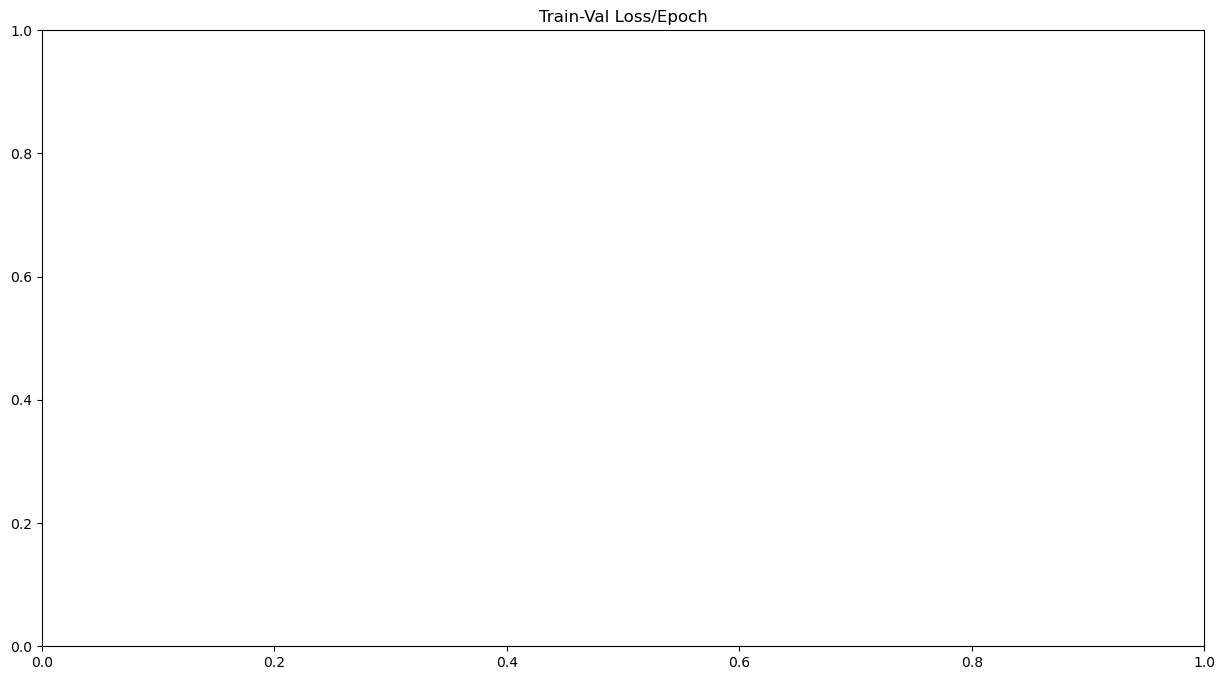

In [18]:
# TODO remove from vscode - for visualisation
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [19]:
def nn_metrics_regression(model: abc.ABCMeta, x_data: torch.Tensor , y_data: torch.Tensor) -> tuple[np.float64, np.float64]: 
    criterion = RMSELoss()
    model.eval()
    with torch.no_grad():
        r2 = 0
        x_data = torch.tensor(x_data).to(torch.float32)
        y_data = torch.tensor(y_data).to(torch.float32)
        prediction = model(x_data)
        rmse = criterion(prediction,y_data)
        rmse = np.float64(rmse)
        
        y_data = y_data.detach().numpy()
        prediction = prediction.detach().numpy()
        r2 += r2_score(y_data,prediction)

    return rmse, r2

In [20]:
# neural network classification metrics.
def nn_metrics_classification(model: abc.ABCMeta, x_data: torch.Tensor , y_data: torch.Tensor) -> tuple[np.float64, np.float64, np.float64, np.float64, dict]: 
    model.eval()
    with torch.no_grad():
        x_data = torch.tensor(x_data).to(torch.float32)
        y_data = torch.tensor(y_data).to(torch.float32)
        output = model(x_data)
        prediction = torch.argmax(output, 1)
        
        y_data = y_data.detach().numpy()
        prediction = prediction.detach().numpy()
        score_f1 = f1_score(y_data, prediction, average='weighted')
        score_precision = precision_score(y_data, prediction, average='weighted')
        score_recall = recall_score(y_data, prediction, average='weighted')
        score_accuracy = accuracy_score(y_data, prediction)
        target_names = ['Beds - 1', 'Beds - 2', 'Beds - 3','Beds - 4','Beds - 5 & above']
        report = classification_report(y_data, prediction, target_names=target_names, output_dict=True)
        print(report)

    return score_accuracy, score_precision, score_recall, score_f1, report

In [21]:

def save_model(trained_model: abc.ABCMeta, best_model_param: dict, model_score: dict, folder: str):
    if isinstance(trained_model, torch.nn.Module):
        with open(os.path.join(folder, "model.pt"), "wb") as out_pt:
            torch.save(trained_model.state_dict(), out_pt )
    else:
        with open(os.path.join(folder, "model.joblib"), "wb") as out_joblib:
            joblib.dump(trained_model, out_joblib)
            
    with open(os.path.join(folder, "hyperparameters.json"), "w") as param_json:
        json.dump(best_model_param, param_json, indent=4)
    with open(os.path.join(folder, "metrics.json"), "w") as metrics_json:
        json.dump(model_score, metrics_json, indent=4)

In [22]:
def generate_nn_configs(task: str) -> list:
    configs = []
    if task == 'regression':
        config = get_nn_config("nn_regression_config.yaml")
    else:
        config = get_nn_config("nn_classification_config.yaml")
        
    # define different combinations of hyperparameters
    for opt in config['optimiser']:
        for lr in config['learning_rate']:
            for hls in config['hidden_layer_width']:
                for md in config['model_depth']:
                    configs.append({
                        'optimiser': opt,
                        'learning_rate': lr,
                        'hidden_layer_width': hls,
                        'model_depth': md,
                        'input_node_size': config['input_node_size'],
                        'output_node_size': config['output_node_size'],
                        'epoch': config['epoch']
                    })
    
    return configs

In [23]:
def find_best_nn(train_dataloader: D.DataLoader, val_dataloader: D.DataLoader, split_data: tuple, task: str):
    
    # generate configs based on supervised learning task(i.e regression/classification)
    configs = generate_nn_configs(task)
    
    # initialize variables to keep track of best model
    x_train, y_train, x_val, y_val, x_test, y_test = split_data
    best_rmse = float('inf')
    best_accuracy = -float('inf')
    best_config = None
    best_model = None
    
    regression_metrics_dict = {"RMSE_loss": [],
                               "R_squared": [],
                               "training_duration": [],
                               "inference_latency": []}
    
    classification_metrics_dict = {"accuracy": [],
                                   "precision": [],
                                   "recall": [],
                                   "f1_score": [],
                                   "training_duration": [],
                                   "inference_latency": [],
                                   "report": []}
    for config in configs:
        
        # train model
        # Regression NN 
        if task == 'regression':
            trained_model, training_duration, directory = train(train_dataloader, val_dataloader, config, task, model=NNRegressionModel(config))
            
            # train data metrics
            train_rmse , train_r2 = nn_metrics_regression(trained_model, x_train, y_train)
            
            # test data metrics
            start_time = time.time()
            test_rmse , test_r2 = nn_metrics_regression(trained_model, x_test, y_test)
            end_time = time.time()
            test_duration = end_time - start_time
            
            # val data metrics
            val_rmse , val_r2 = nn_metrics_regression(trained_model, x_val, y_val)

            # Append dict of performance metrics
            regression_metrics_dict['RMSE_loss'] = {'train': train_rmse, 'test': test_rmse, 'val': val_rmse}
            regression_metrics_dict['R_squared'] = {'train': train_r2, 'test': test_r2, 'val': val_r2}
            regression_metrics_dict['training_duration'] = training_duration
            regression_metrics_dict['inference_latency'] = test_duration/len(x_test)
            hyperparameters_nn=config
            save_model(trained_model, hyperparameters_nn, regression_metrics_dict, folder = directory)

            if test_rmse < best_rmse:
                best_rmse = test_rmse
                save_model(trained_model, hyperparameters_nn, regression_metrics_dict, folder = os.path.join('models', 'regression', 'neural_networks'))
            else:
                pass
            
        # Classification NN 
        else:
            # train model      
            trained_model, training_duration, directory = train(train_dataloader, val_dataloader, config, task, model=NNClassificationModel(config))

            
            # train data metrics
            train_score= nn_metrics_classification(trained_model, x_train, y_train)

            # test data metrics
            start_time = time.time()
            test_score = nn_metrics_classification(trained_model, x_test, y_test)
            end_time = time.time()

            test_duration = end_time - start_time

            # val data metrics
            val_score = nn_metrics_classification(trained_model, x_val, y_val)


            # Append dict of performance metrics
            classification_metrics_dict['accuracy'] = {'train': train_score[0], 'test': test_score[0], 'val': val_score[0]}
            classification_metrics_dict['precision'] = {'train': train_score[1], 'test': test_score[1], 'val': val_score[1]}
            classification_metrics_dict['recall'] = {'train': train_score[2], 'test': test_score[2], 'val': val_score[2]}
            classification_metrics_dict['f1_score']= {'train': train_score[3], 'test': test_score[3], 'val': val_score[3]}
            classification_metrics_dict['training_duration'] = training_duration
            classification_metrics_dict['inference_latency'] = test_duration/len(x_test)
            classification_metrics_dict['report'] = {'train': train_score[4], 'test': test_score[4], 'val': val_score[4]}
            hyperparameters_nn=config
            save_model(trained_model, hyperparameters_nn, classification_metrics_dict, folder = directory)

            if test_score[0] > best_accuracy:
                best_accuracy = test_score[0]
                save_model(trained_model, hyperparameters_nn, classification_metrics_dict, folder = os.path.join('models', 'classification', 'neural_networks'))
            else:
                pass


In [24]:
'''
# read the dataset
dataset = pd.read_csv("clean_tabular_data.csv")

# for nn classification model 
target = 'bedrooms'
numeric = False

# set the supervised learning task to classification
task = 'classification'

# data preprocessing and stored in features(independent data) and label(target data)
features,label = get_processed_data(dataset, target, numeric=False)

# here split_data is a tuple where (x_train, y_train, x_val, y_val, x_test, y_test) 
# is stored by calling get_split_data()
split_data = get_split_data(features, label, task)

# here  by calling get_dataloader(), unpack the tuple split_data within function to use the split data further
train_dataloader, test_dataloader, val_dataloader = get_dataloader(split_data, task)

# get the best model, it's metrics and the best parameters
find_best_nn(train_dataloader, val_dataloader, split_data, task)
'''

'\n# read the dataset\ndataset = pd.read_csv("clean_tabular_data.csv")\n\n# for nn classification model \ntarget = \'bedrooms\'\nnumeric = False\n\n# set the supervised learning task to classification\ntask = \'classification\'\n\n# data preprocessing and stored in features(independent data) and label(target data)\nfeatures,label = get_processed_data(dataset, target, numeric=False)\n\n# here split_data is a tuple where (x_train, y_train, x_val, y_val, x_test, y_test) \n# is stored by calling get_split_data()\nsplit_data = get_split_data(features, label, task)\n\n# here  by calling get_dataloader(), unpack the tuple split_data within function to use the split data further\ntrain_dataloader, test_dataloader, val_dataloader = get_dataloader(split_data, task)\n\n# get the best model, it\'s metrics and the best parameters\nfind_best_nn(train_dataloader, val_dataloader, split_data, task)\n'

Epoch 000: | Train MSE: 40831.38 | Val MSE: 1150830.92
Epoch 001: | Train MSE: 52358.75 | Val MSE: 41029.51
Epoch 002: | Train MSE: 50827.37 | Val MSE: 38071.28
Epoch 003: | Train MSE: 41141.61 | Val MSE: 33409.94
Epoch 004: | Train MSE: 36338.50 | Val MSE: 20600.68
Epoch 005: | Train MSE: 19005.95 | Val MSE: 13049.13
Epoch 006: | Train MSE: 17186.22 | Val MSE: 13619.94
Epoch 007: | Train MSE: 17185.81 | Val MSE: 12587.10
Epoch 008: | Train MSE: 17185.79 | Val MSE: 13316.54
Epoch 009: | Train MSE: 17185.77 | Val MSE: 13937.80
Epoch 010: | Train MSE: 17185.74 | Val MSE: 13484.12
Epoch 011: | Train MSE: 17185.72 | Val MSE: 13431.44
Epoch 012: | Train MSE: 17185.71 | Val MSE: 13503.00
Epoch 013: | Train MSE: 17185.69 | Val MSE: 14919.27
Epoch 014: | Train MSE: 17185.67 | Val MSE: 14053.28
Epoch 015: | Train MSE: 17185.65 | Val MSE: 12838.99
Epoch 016: | Train MSE: 17185.63 | Val MSE: 13003.42
Epoch 017: | Train MSE: 17185.62 | Val MSE: 12897.93
Epoch 018: | Train MSE: 17185.60 | Val MSE: 

Epoch 169: | Train MSE: 17183.79 | Val MSE: 13869.03
Epoch 170: | Train MSE: 17183.78 | Val MSE: 13079.26
Epoch 171: | Train MSE: 17183.77 | Val MSE: 14477.37
Epoch 172: | Train MSE: 17183.76 | Val MSE: 13186.90
Epoch 173: | Train MSE: 17183.75 | Val MSE: 13413.80
Epoch 174: | Train MSE: 17183.73 | Val MSE: 14227.47
Epoch 175: | Train MSE: 17183.72 | Val MSE: 13702.76
Epoch 176: | Train MSE: 17183.71 | Val MSE: 13987.67
Epoch 177: | Train MSE: 17183.70 | Val MSE: 13389.93
Epoch 178: | Train MSE: 17183.69 | Val MSE: 13827.93
Epoch 179: | Train MSE: 17183.68 | Val MSE: 14644.83
Epoch 180: | Train MSE: 17183.67 | Val MSE: 14239.77
Epoch 181: | Train MSE: 17183.66 | Val MSE: 13631.17
Epoch 182: | Train MSE: 17183.65 | Val MSE: 13428.13
Epoch 183: | Train MSE: 17183.64 | Val MSE: 13871.97
Epoch 184: | Train MSE: 17183.63 | Val MSE: 14180.27
Epoch 185: | Train MSE: 17183.62 | Val MSE: 13913.81
Epoch 186: | Train MSE: 17183.61 | Val MSE: 12834.06
Epoch 187: | Train MSE: 17183.60 | Val MSE: 13

Epoch 126: | Train MSE: 17211.48 | Val MSE: 14450.05
Epoch 127: | Train MSE: 17205.29 | Val MSE: 13413.22
Epoch 128: | Train MSE: 17199.34 | Val MSE: 12522.87
Epoch 129: | Train MSE: 17193.62 | Val MSE: 13686.35
Epoch 130: | Train MSE: 17188.13 | Val MSE: 13524.03
Epoch 131: | Train MSE: 17182.85 | Val MSE: 14042.72
Epoch 132: | Train MSE: 17177.78 | Val MSE: 14061.50
Epoch 133: | Train MSE: 17172.90 | Val MSE: 13835.73
Epoch 134: | Train MSE: 17168.22 | Val MSE: 13783.89
Epoch 135: | Train MSE: 17163.72 | Val MSE: 14827.19
Epoch 136: | Train MSE: 17159.40 | Val MSE: 13536.54
Epoch 137: | Train MSE: 17155.24 | Val MSE: 14357.18
Epoch 138: | Train MSE: 17151.25 | Val MSE: 13539.82
Epoch 139: | Train MSE: 17147.42 | Val MSE: 14722.77
Epoch 140: | Train MSE: 17143.73 | Val MSE: 13520.98
Epoch 141: | Train MSE: 17140.19 | Val MSE: 13656.47
Epoch 142: | Train MSE: 17136.79 | Val MSE: 13715.09
Epoch 143: | Train MSE: 17133.52 | Val MSE: 13685.20
Epoch 144: | Train MSE: 17130.38 | Val MSE: 14

Epoch 081: | Train MSE: 17220.50 | Val MSE: 14103.55
Epoch 082: | Train MSE: 17220.00 | Val MSE: 14029.85
Epoch 083: | Train MSE: 17219.51 | Val MSE: 15319.21
Epoch 084: | Train MSE: 17219.03 | Val MSE: 12707.06
Epoch 085: | Train MSE: 17218.57 | Val MSE: 12992.65
Epoch 086: | Train MSE: 17218.12 | Val MSE: 14731.03
Epoch 087: | Train MSE: 17217.68 | Val MSE: 14189.29
Epoch 088: | Train MSE: 17217.25 | Val MSE: 13122.76
Epoch 089: | Train MSE: 17216.84 | Val MSE: 13801.13
Epoch 090: | Train MSE: 17216.43 | Val MSE: 12877.24
Epoch 091: | Train MSE: 17216.04 | Val MSE: 14026.87
Epoch 092: | Train MSE: 17215.65 | Val MSE: 14269.39
Epoch 093: | Train MSE: 17215.28 | Val MSE: 13113.59
Epoch 094: | Train MSE: 17214.91 | Val MSE: 13274.72
Epoch 095: | Train MSE: 17214.56 | Val MSE: 14091.48
Epoch 096: | Train MSE: 17214.21 | Val MSE: 13982.59
Epoch 097: | Train MSE: 17213.87 | Val MSE: 14499.71
Epoch 098: | Train MSE: 17213.54 | Val MSE: 14314.39
Epoch 099: | Train MSE: 17213.22 | Val MSE: 13

Epoch 037: | Train MSE: 22774.81 | Val MSE: 17005.86
Epoch 038: | Train MSE: 22550.39 | Val MSE: 17237.63
Epoch 039: | Train MSE: 22334.78 | Val MSE: 17017.50
Epoch 040: | Train MSE: 22127.63 | Val MSE: 17672.33
Epoch 041: | Train MSE: 21928.60 | Val MSE: 16003.17
Epoch 042: | Train MSE: 21737.39 | Val MSE: 17263.54
Epoch 043: | Train MSE: 21553.68 | Val MSE: 15952.05
Epoch 044: | Train MSE: 21377.17 | Val MSE: 16740.61
Epoch 045: | Train MSE: 21207.59 | Val MSE: 16080.86
Epoch 046: | Train MSE: 21044.67 | Val MSE: 15616.14
Epoch 047: | Train MSE: 20888.13 | Val MSE: 15566.75
Epoch 048: | Train MSE: 20737.74 | Val MSE: 16492.78
Epoch 049: | Train MSE: 20593.25 | Val MSE: 16018.94
Epoch 050: | Train MSE: 20454.43 | Val MSE: 17049.95
Epoch 051: | Train MSE: 20321.05 | Val MSE: 16437.38
Epoch 052: | Train MSE: 20192.91 | Val MSE: 15839.84
Epoch 053: | Train MSE: 20069.79 | Val MSE: 15928.48
Epoch 054: | Train MSE: 19951.50 | Val MSE: 15465.57
Epoch 055: | Train MSE: 19837.86 | Val MSE: 14

Epoch 192: | Train MSE: 17064.89 | Val MSE: 13104.83
Epoch 193: | Train MSE: 17064.43 | Val MSE: 13177.73
Epoch 194: | Train MSE: 17063.99 | Val MSE: 14118.07
Epoch 195: | Train MSE: 17063.56 | Val MSE: 13943.99
Epoch 196: | Train MSE: 17063.15 | Val MSE: 13357.43
Epoch 197: | Train MSE: 17062.76 | Val MSE: 13548.65
Epoch 198: | Train MSE: 17062.39 | Val MSE: 13738.64
Epoch 199: | Train MSE: 17062.02 | Val MSE: 13507.20
Epoch 000: | Train MSE: 34878.73 | Val MSE: 18181.53
Epoch 001: | Train MSE: 34733.45 | Val MSE: 21384.26
Epoch 002: | Train MSE: 19333.80 | Val MSE: 13943.55
Epoch 003: | Train MSE: 17343.14 | Val MSE: 13840.08
Epoch 004: | Train MSE: 17355.44 | Val MSE: 13793.23
Epoch 005: | Train MSE: 17364.39 | Val MSE: 15545.30
Epoch 006: | Train MSE: 17369.40 | Val MSE: 15509.75
Epoch 007: | Train MSE: 17370.18 | Val MSE: 13230.56
Epoch 008: | Train MSE: 17367.27 | Val MSE: 15131.46
Epoch 009: | Train MSE: 17361.60 | Val MSE: 15016.69
Epoch 010: | Train MSE: 17354.11 | Val MSE: 14

Epoch 150: | Train MSE: 17179.58 | Val MSE: 14366.38
Epoch 151: | Train MSE: 17179.49 | Val MSE: 14000.66
Epoch 152: | Train MSE: 17179.40 | Val MSE: 15067.72
Epoch 153: | Train MSE: 17179.32 | Val MSE: 13745.87
Epoch 154: | Train MSE: 17179.23 | Val MSE: 13719.43
Epoch 155: | Train MSE: 17179.14 | Val MSE: 14910.58
Epoch 156: | Train MSE: 17179.06 | Val MSE: 13000.33
Epoch 157: | Train MSE: 17178.98 | Val MSE: 14978.09
Epoch 158: | Train MSE: 17178.89 | Val MSE: 13646.50
Epoch 159: | Train MSE: 17178.81 | Val MSE: 13739.16
Epoch 160: | Train MSE: 17178.73 | Val MSE: 13276.23
Epoch 161: | Train MSE: 17178.65 | Val MSE: 13660.66
Epoch 162: | Train MSE: 17178.57 | Val MSE: 14158.19
Epoch 163: | Train MSE: 17178.49 | Val MSE: 13298.25
Epoch 164: | Train MSE: 17178.42 | Val MSE: 13305.72
Epoch 165: | Train MSE: 17178.34 | Val MSE: 13764.88
Epoch 166: | Train MSE: 17178.26 | Val MSE: 13481.00
Epoch 167: | Train MSE: 17178.19 | Val MSE: 13984.40
Epoch 168: | Train MSE: 17178.11 | Val MSE: 13

Epoch 107: | Train MSE: 17163.27 | Val MSE: 12698.78
Epoch 108: | Train MSE: 17163.26 | Val MSE: 14351.15
Epoch 109: | Train MSE: 17163.25 | Val MSE: 13555.46
Epoch 110: | Train MSE: 17163.24 | Val MSE: 13764.57
Epoch 111: | Train MSE: 17163.23 | Val MSE: 12676.39
Epoch 112: | Train MSE: 17163.22 | Val MSE: 13765.45
Epoch 113: | Train MSE: 17163.21 | Val MSE: 14369.53
Epoch 114: | Train MSE: 17163.20 | Val MSE: 13813.58
Epoch 115: | Train MSE: 17163.19 | Val MSE: 12813.75
Epoch 116: | Train MSE: 17163.19 | Val MSE: 14588.30
Epoch 117: | Train MSE: 17163.18 | Val MSE: 13695.25
Epoch 118: | Train MSE: 17163.17 | Val MSE: 13987.42
Epoch 119: | Train MSE: 17163.16 | Val MSE: 13118.83
Epoch 120: | Train MSE: 17163.15 | Val MSE: 12785.47
Epoch 121: | Train MSE: 17163.14 | Val MSE: 12660.51
Epoch 122: | Train MSE: 17163.13 | Val MSE: 14144.82
Epoch 123: | Train MSE: 17163.12 | Val MSE: 13517.96
Epoch 124: | Train MSE: 17163.11 | Val MSE: 13061.18
Epoch 125: | Train MSE: 17163.11 | Val MSE: 14

Epoch 073: | Train MSE: 17255.93 | Val MSE: 13642.37
Epoch 074: | Train MSE: 17255.00 | Val MSE: 13917.61
Epoch 075: | Train MSE: 17254.09 | Val MSE: 15046.97
Epoch 076: | Train MSE: 17253.20 | Val MSE: 13306.97
Epoch 077: | Train MSE: 17252.34 | Val MSE: 14593.81
Epoch 078: | Train MSE: 17251.51 | Val MSE: 13247.52
Epoch 079: | Train MSE: 17250.70 | Val MSE: 13917.46
Epoch 080: | Train MSE: 17249.90 | Val MSE: 12777.95
Epoch 081: | Train MSE: 17249.13 | Val MSE: 12555.41
Epoch 082: | Train MSE: 17248.38 | Val MSE: 13992.56
Epoch 083: | Train MSE: 17247.65 | Val MSE: 13379.69
Epoch 084: | Train MSE: 17246.94 | Val MSE: 12616.71
Epoch 085: | Train MSE: 17246.25 | Val MSE: 13611.55
Epoch 086: | Train MSE: 17245.57 | Val MSE: 13395.39
Epoch 087: | Train MSE: 17244.91 | Val MSE: 13649.47
Epoch 088: | Train MSE: 17244.27 | Val MSE: 14651.18
Epoch 089: | Train MSE: 17243.64 | Val MSE: 12668.38
Epoch 090: | Train MSE: 17243.03 | Val MSE: 13678.88
Epoch 091: | Train MSE: 17242.43 | Val MSE: 13

Epoch 035: | Train MSE: 17289.38 | Val MSE: 13573.84
Epoch 036: | Train MSE: 17287.28 | Val MSE: 12945.07
Epoch 037: | Train MSE: 17285.26 | Val MSE: 14796.25
Epoch 038: | Train MSE: 17283.32 | Val MSE: 12892.82
Epoch 039: | Train MSE: 17281.46 | Val MSE: 14340.90
Epoch 040: | Train MSE: 17279.67 | Val MSE: 15193.61
Epoch 041: | Train MSE: 17277.96 | Val MSE: 14562.35
Epoch 042: | Train MSE: 17276.30 | Val MSE: 14661.50
Epoch 043: | Train MSE: 17274.71 | Val MSE: 13488.48
Epoch 044: | Train MSE: 17273.18 | Val MSE: 14055.23
Epoch 045: | Train MSE: 17271.71 | Val MSE: 14456.06
Epoch 046: | Train MSE: 17270.28 | Val MSE: 13880.03
Epoch 047: | Train MSE: 17268.91 | Val MSE: 13692.62
Epoch 048: | Train MSE: 17267.59 | Val MSE: 14205.08
Epoch 049: | Train MSE: 17266.31 | Val MSE: 14021.57
Epoch 050: | Train MSE: 17265.08 | Val MSE: 14662.31
Epoch 051: | Train MSE: 17263.89 | Val MSE: 14396.78
Epoch 052: | Train MSE: 17262.73 | Val MSE: 14365.74
Epoch 053: | Train MSE: 17261.62 | Val MSE: 13

Epoch 195: | Train MSE: 17212.97 | Val MSE: 13914.97
Epoch 196: | Train MSE: 17212.85 | Val MSE: 14336.21
Epoch 197: | Train MSE: 17212.73 | Val MSE: 13142.76
Epoch 198: | Train MSE: 17212.61 | Val MSE: 13677.40
Epoch 199: | Train MSE: 17212.50 | Val MSE: 14560.42
Epoch 000: | Train MSE: 1212475.78 | Val MSE: 39937.54
Epoch 001: | Train MSE: 42699.34 | Val MSE: 36011.78
Epoch 002: | Train MSE: 41442.21 | Val MSE: 34457.98
Epoch 003: | Train MSE: 40467.17 | Val MSE: 35077.48
Epoch 004: | Train MSE: 39541.87 | Val MSE: 34179.10
Epoch 005: | Train MSE: 38656.16 | Val MSE: 31140.24
Epoch 006: | Train MSE: 37806.58 | Val MSE: 30756.90
Epoch 007: | Train MSE: 36991.02 | Val MSE: 31043.63
Epoch 008: | Train MSE: 36207.87 | Val MSE: 30273.16
Epoch 009: | Train MSE: 35455.69 | Val MSE: 29068.97
Epoch 010: | Train MSE: 34733.20 | Val MSE: 30549.97
Epoch 011: | Train MSE: 34039.17 | Val MSE: 28317.60
Epoch 012: | Train MSE: 33372.45 | Val MSE: 26420.41
Epoch 013: | Train MSE: 32731.95 | Val MSE: 

Epoch 155: | Train MSE: 17106.97 | Val MSE: 13488.12
Epoch 156: | Train MSE: 17104.87 | Val MSE: 14669.21
Epoch 157: | Train MSE: 17102.85 | Val MSE: 12883.25
Epoch 158: | Train MSE: 17100.91 | Val MSE: 12788.50
Epoch 159: | Train MSE: 17099.04 | Val MSE: 13802.29
Epoch 160: | Train MSE: 17097.25 | Val MSE: 14357.36
Epoch 161: | Train MSE: 17095.53 | Val MSE: 14684.99
Epoch 162: | Train MSE: 17093.87 | Val MSE: 13992.92
Epoch 163: | Train MSE: 17092.28 | Val MSE: 13888.32
Epoch 164: | Train MSE: 17090.75 | Val MSE: 12946.49
Epoch 165: | Train MSE: 17089.28 | Val MSE: 14123.06
Epoch 166: | Train MSE: 17087.87 | Val MSE: 13385.91
Epoch 167: | Train MSE: 17086.52 | Val MSE: 13362.64
Epoch 168: | Train MSE: 17085.21 | Val MSE: 13808.66
Epoch 169: | Train MSE: 17083.96 | Val MSE: 13700.60
Epoch 170: | Train MSE: 17082.76 | Val MSE: 13169.74
Epoch 171: | Train MSE: 17081.60 | Val MSE: 13294.25
Epoch 172: | Train MSE: 17080.49 | Val MSE: 13977.48
Epoch 173: | Train MSE: 17079.42 | Val MSE: 13

Epoch 116: | Train MSE: 17198.72 | Val MSE: 13121.09
Epoch 117: | Train MSE: 17198.31 | Val MSE: 13850.48
Epoch 118: | Train MSE: 17197.91 | Val MSE: 13769.65
Epoch 119: | Train MSE: 17197.52 | Val MSE: 13137.80
Epoch 120: | Train MSE: 17197.14 | Val MSE: 13917.66
Epoch 121: | Train MSE: 17196.76 | Val MSE: 14339.26
Epoch 122: | Train MSE: 17196.39 | Val MSE: 13153.13
Epoch 123: | Train MSE: 17196.03 | Val MSE: 13775.31
Epoch 124: | Train MSE: 17195.67 | Val MSE: 14513.74
Epoch 125: | Train MSE: 17195.32 | Val MSE: 14058.25
Epoch 126: | Train MSE: 17194.98 | Val MSE: 13993.19
Epoch 127: | Train MSE: 17194.64 | Val MSE: 14057.31
Epoch 128: | Train MSE: 17194.31 | Val MSE: 12712.70
Epoch 129: | Train MSE: 17193.98 | Val MSE: 12818.15
Epoch 130: | Train MSE: 17193.66 | Val MSE: 13444.35
Epoch 131: | Train MSE: 17193.34 | Val MSE: 14110.09
Epoch 132: | Train MSE: 17193.03 | Val MSE: 13087.30
Epoch 133: | Train MSE: 17192.72 | Val MSE: 13384.05
Epoch 134: | Train MSE: 17192.42 | Val MSE: 14

Epoch 076: | Train MSE: 17057.30 | Val MSE: 12757.87
Epoch 077: | Train MSE: 17057.30 | Val MSE: 13872.87
Epoch 078: | Train MSE: 17057.30 | Val MSE: 13213.50
Epoch 079: | Train MSE: 17057.30 | Val MSE: 14199.55
Epoch 080: | Train MSE: 17057.30 | Val MSE: 13168.43
Epoch 081: | Train MSE: 17057.30 | Val MSE: 14493.60
Epoch 082: | Train MSE: 17057.30 | Val MSE: 13567.97
Epoch 083: | Train MSE: 17057.30 | Val MSE: 14495.19
Epoch 084: | Train MSE: 17057.30 | Val MSE: 14622.20
Epoch 085: | Train MSE: 17057.30 | Val MSE: 14035.80
Epoch 086: | Train MSE: 17057.30 | Val MSE: 12976.60
Epoch 087: | Train MSE: 17057.30 | Val MSE: 14600.50
Epoch 088: | Train MSE: 17057.30 | Val MSE: 14265.79
Epoch 089: | Train MSE: 17057.30 | Val MSE: 12752.74
Epoch 090: | Train MSE: 17057.30 | Val MSE: 12814.42
Epoch 091: | Train MSE: 17057.30 | Val MSE: 14555.10
Epoch 092: | Train MSE: 17057.30 | Val MSE: 12962.00
Epoch 093: | Train MSE: 17057.30 | Val MSE: 13954.28
Epoch 094: | Train MSE: 17057.30 | Val MSE: 14

Epoch 046: | Train MSE: nan | Val MSE: nan
Epoch 047: | Train MSE: nan | Val MSE: nan
Epoch 048: | Train MSE: nan | Val MSE: nan
Epoch 049: | Train MSE: nan | Val MSE: nan
Epoch 050: | Train MSE: nan | Val MSE: nan
Epoch 051: | Train MSE: nan | Val MSE: nan
Epoch 052: | Train MSE: nan | Val MSE: nan
Epoch 053: | Train MSE: nan | Val MSE: nan
Epoch 054: | Train MSE: nan | Val MSE: nan
Epoch 055: | Train MSE: nan | Val MSE: nan
Epoch 056: | Train MSE: nan | Val MSE: nan
Epoch 057: | Train MSE: nan | Val MSE: nan
Epoch 058: | Train MSE: nan | Val MSE: nan
Epoch 059: | Train MSE: nan | Val MSE: nan
Epoch 060: | Train MSE: nan | Val MSE: nan
Epoch 061: | Train MSE: nan | Val MSE: nan
Epoch 062: | Train MSE: nan | Val MSE: nan
Epoch 063: | Train MSE: nan | Val MSE: nan
Epoch 064: | Train MSE: nan | Val MSE: nan
Epoch 065: | Train MSE: nan | Val MSE: nan
Epoch 066: | Train MSE: nan | Val MSE: nan
Epoch 067: | Train MSE: nan | Val MSE: nan
Epoch 068: | Train MSE: nan | Val MSE: nan
Epoch 069: 

ValueError: Input contains NaN.

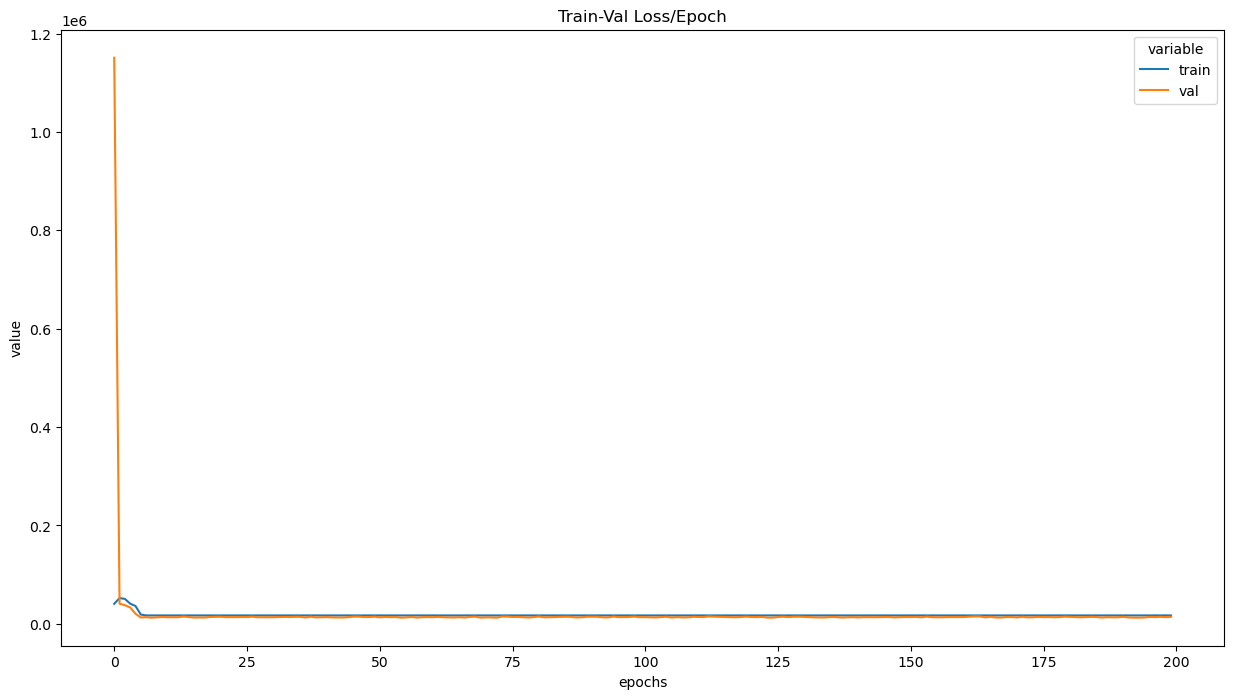

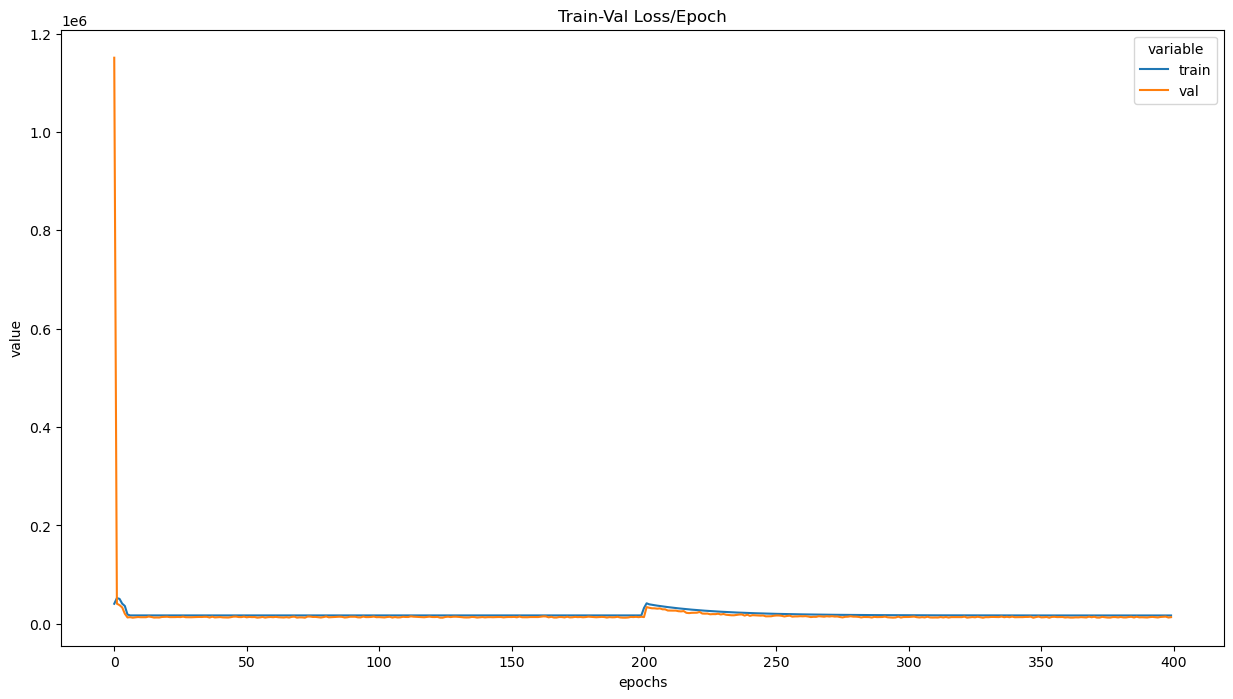

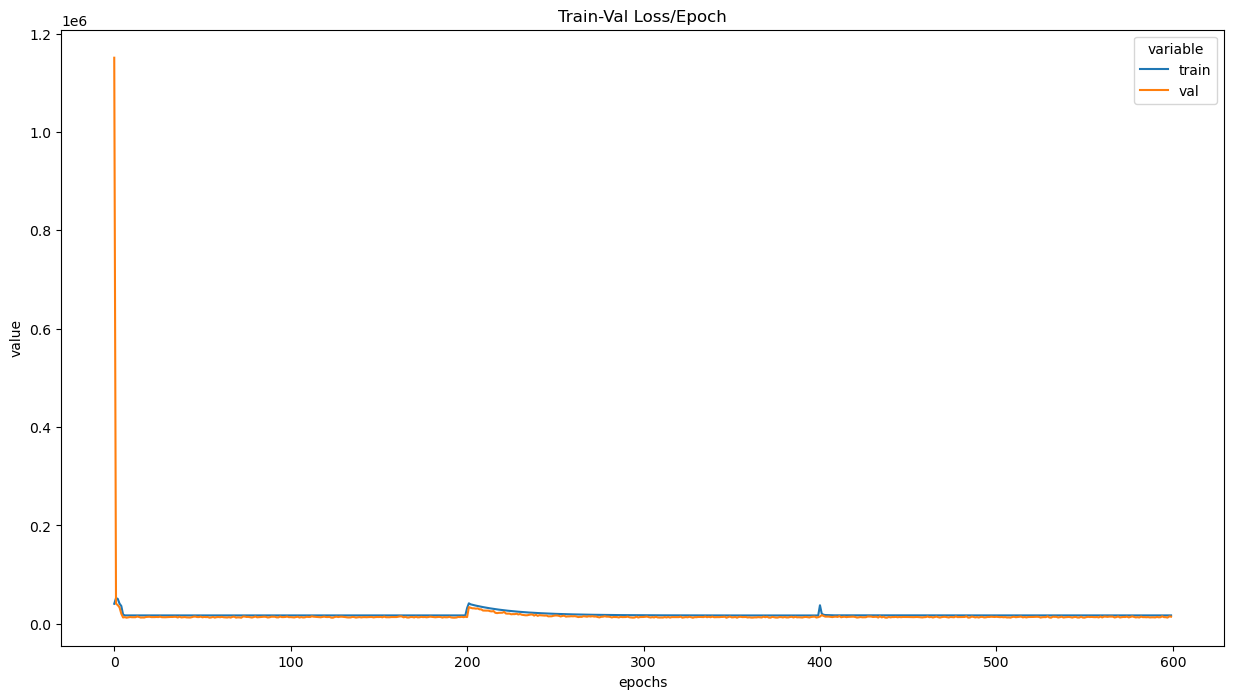

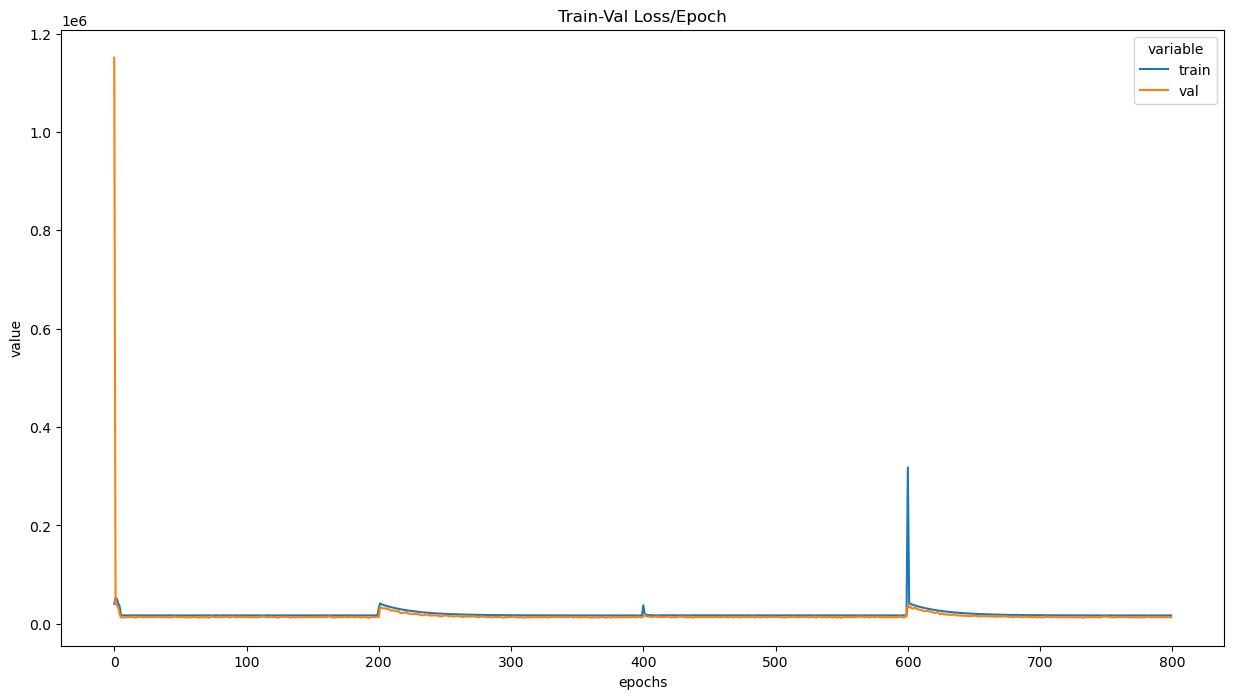

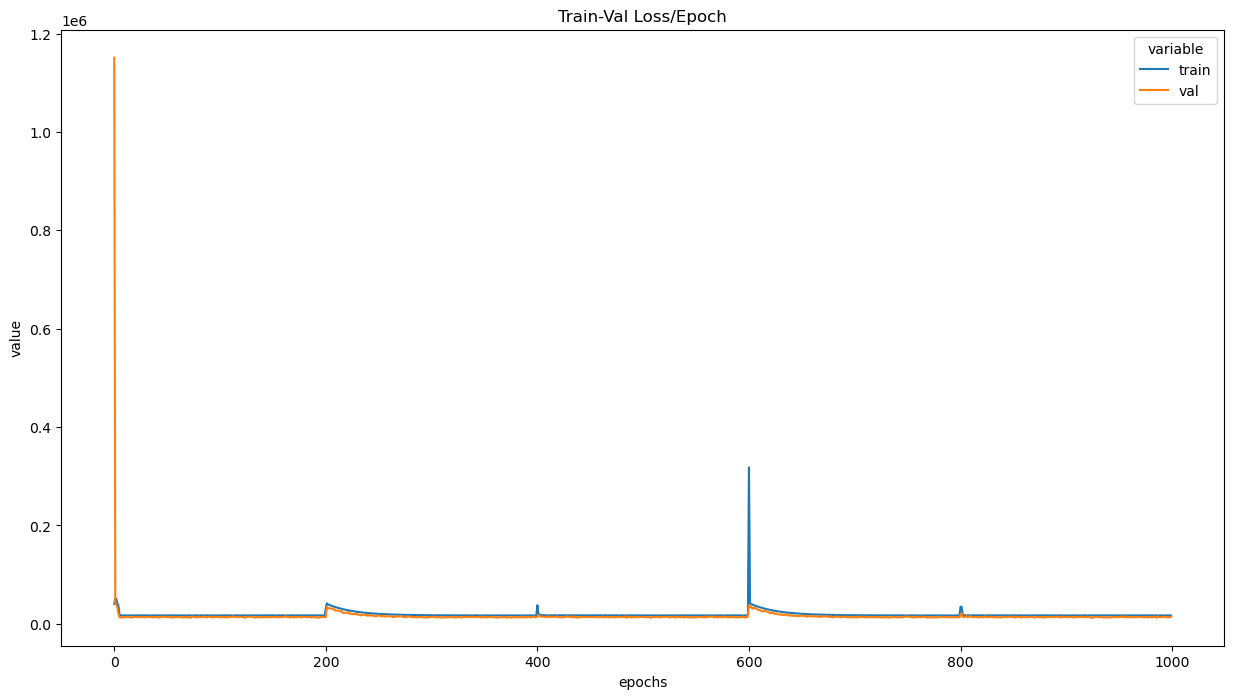

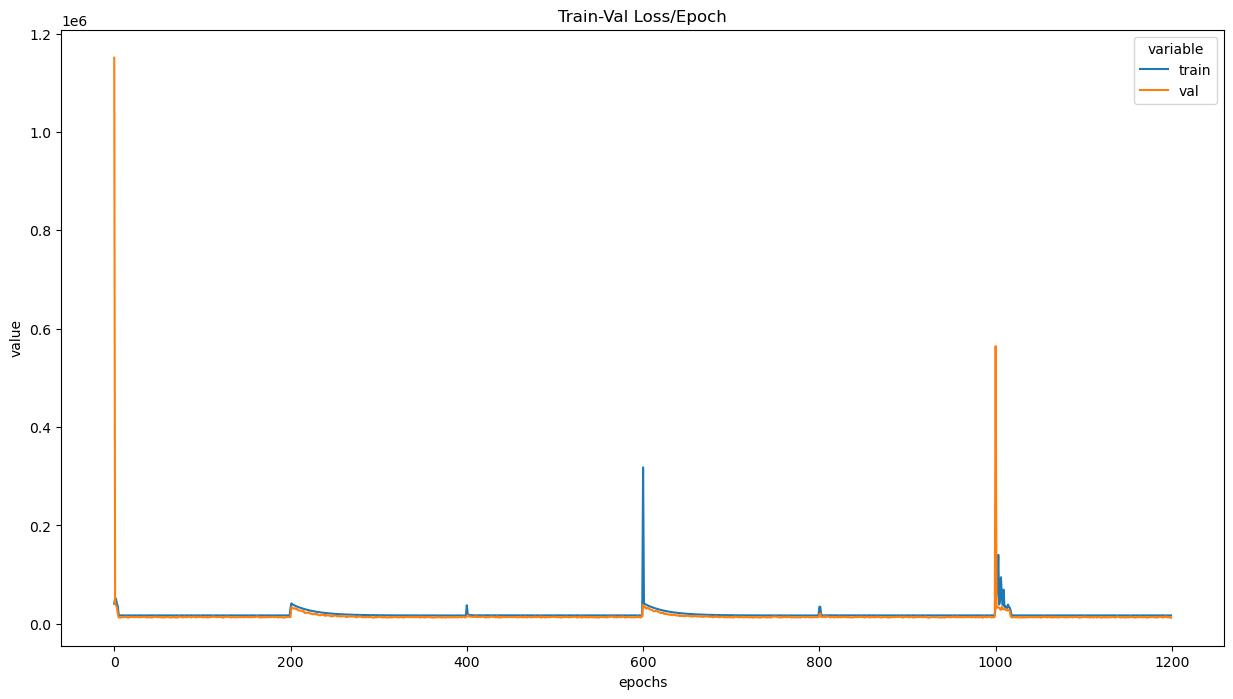

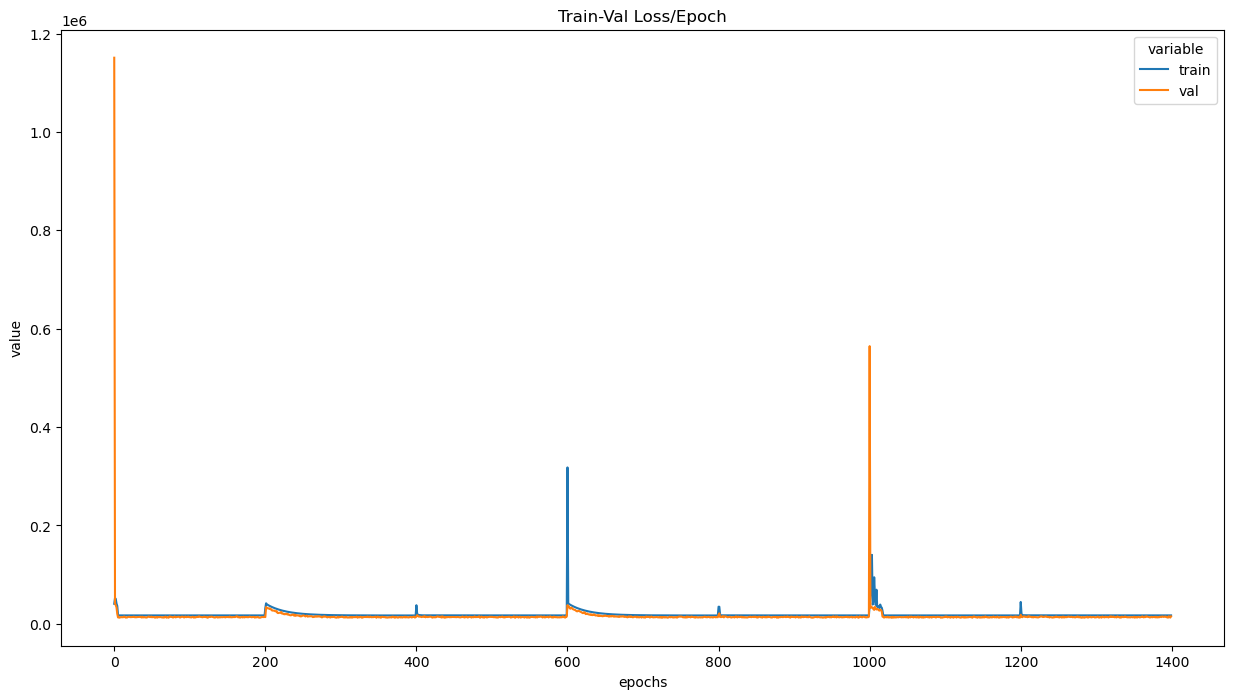

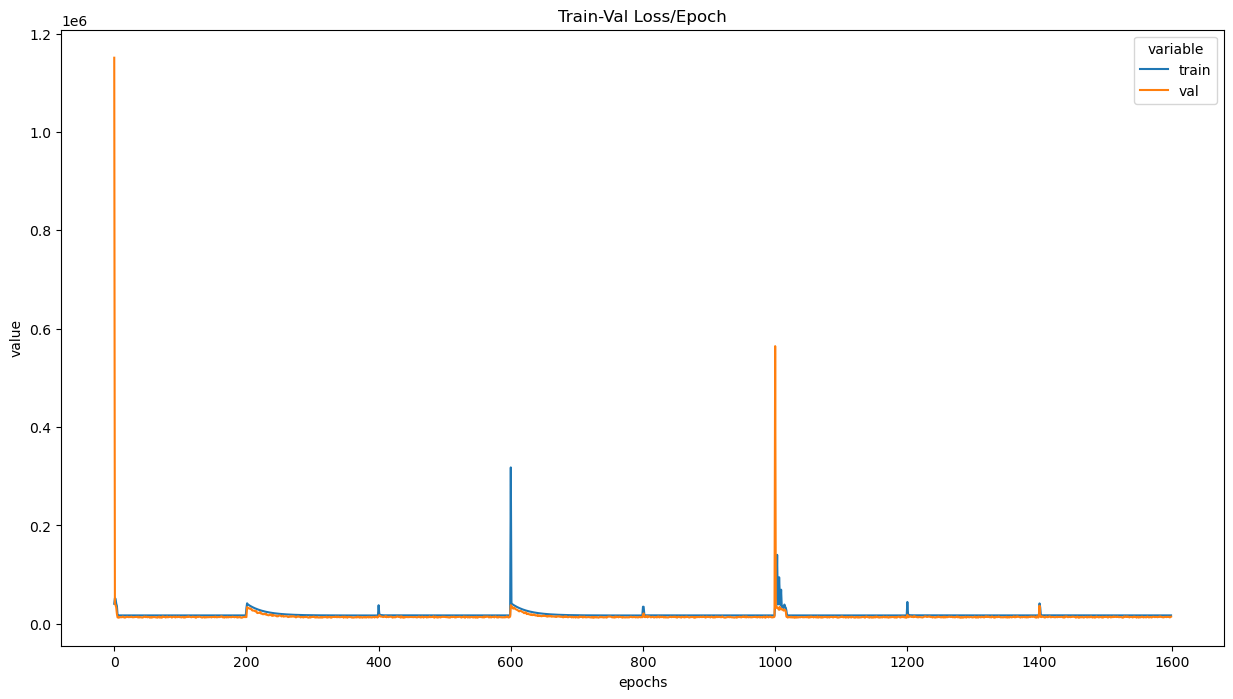

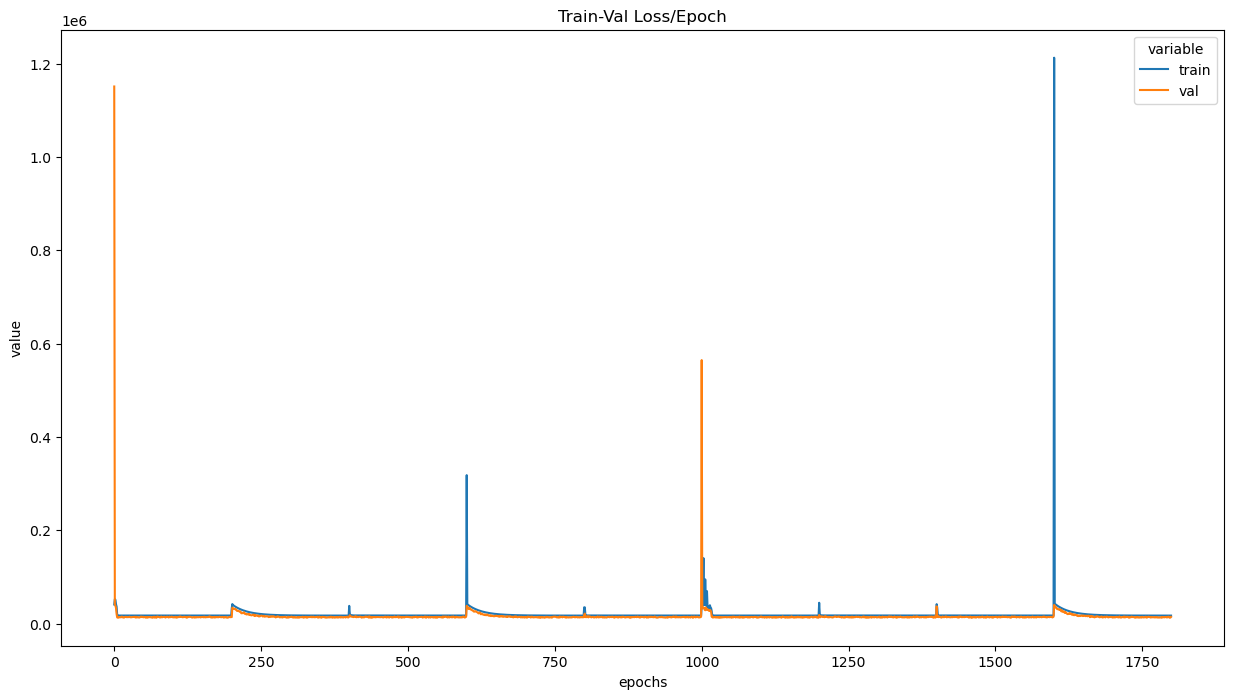

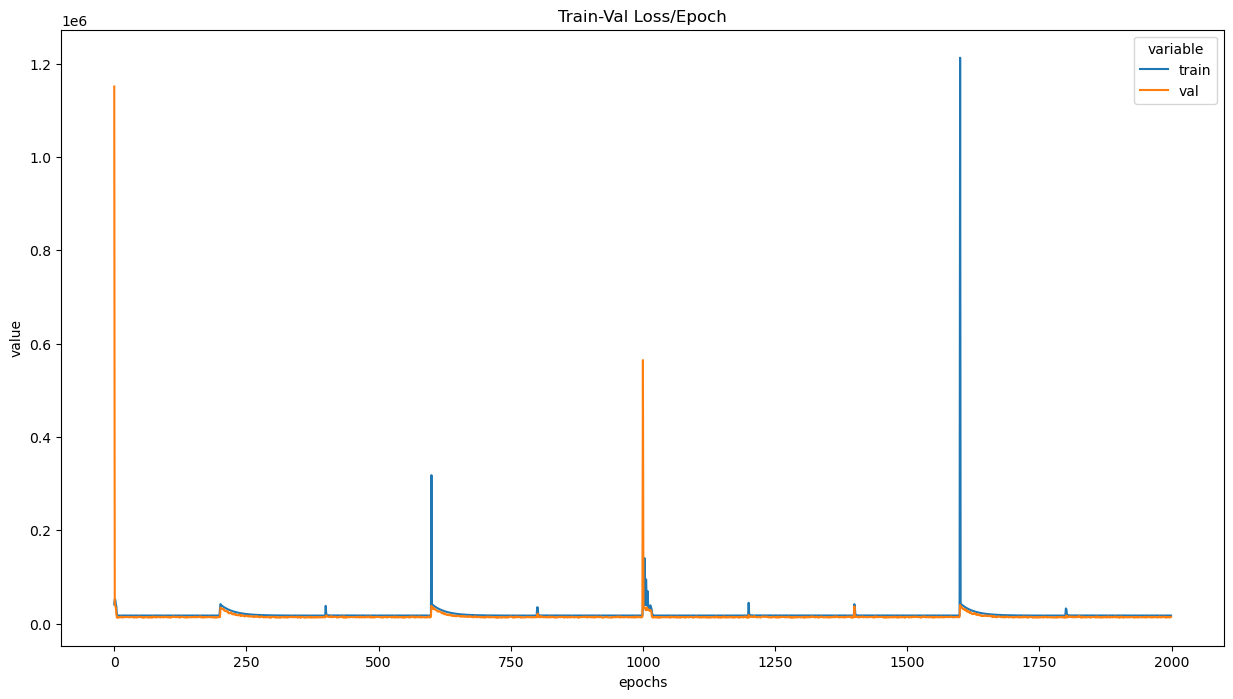

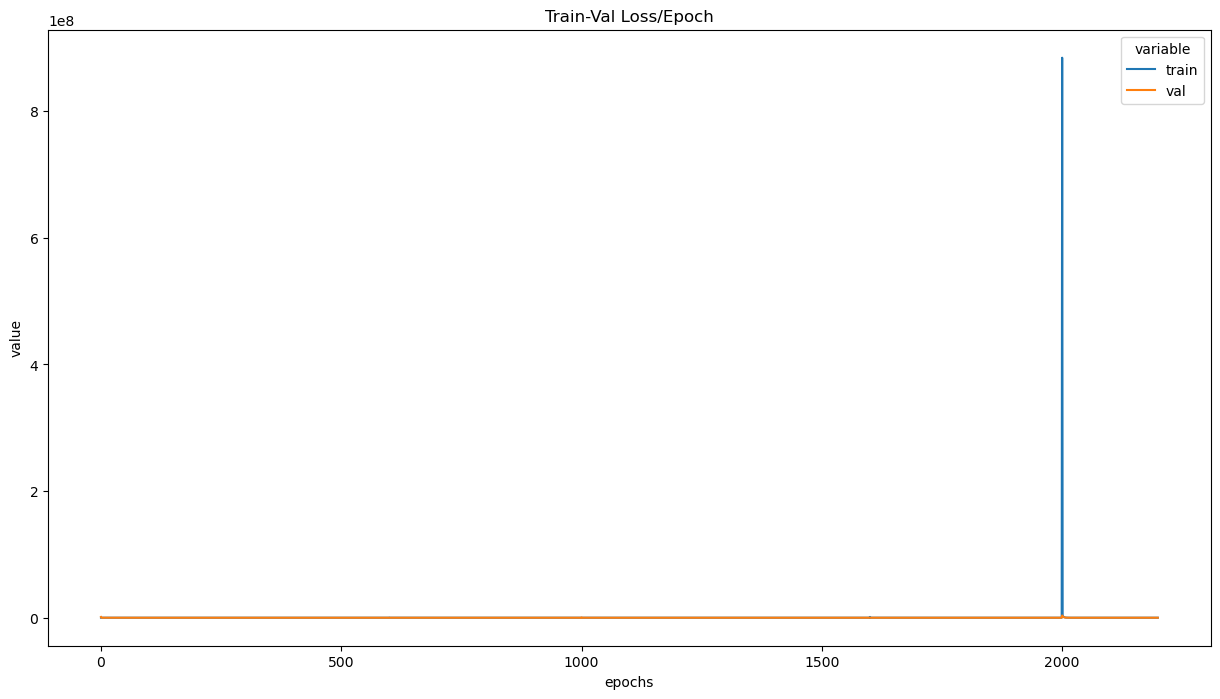

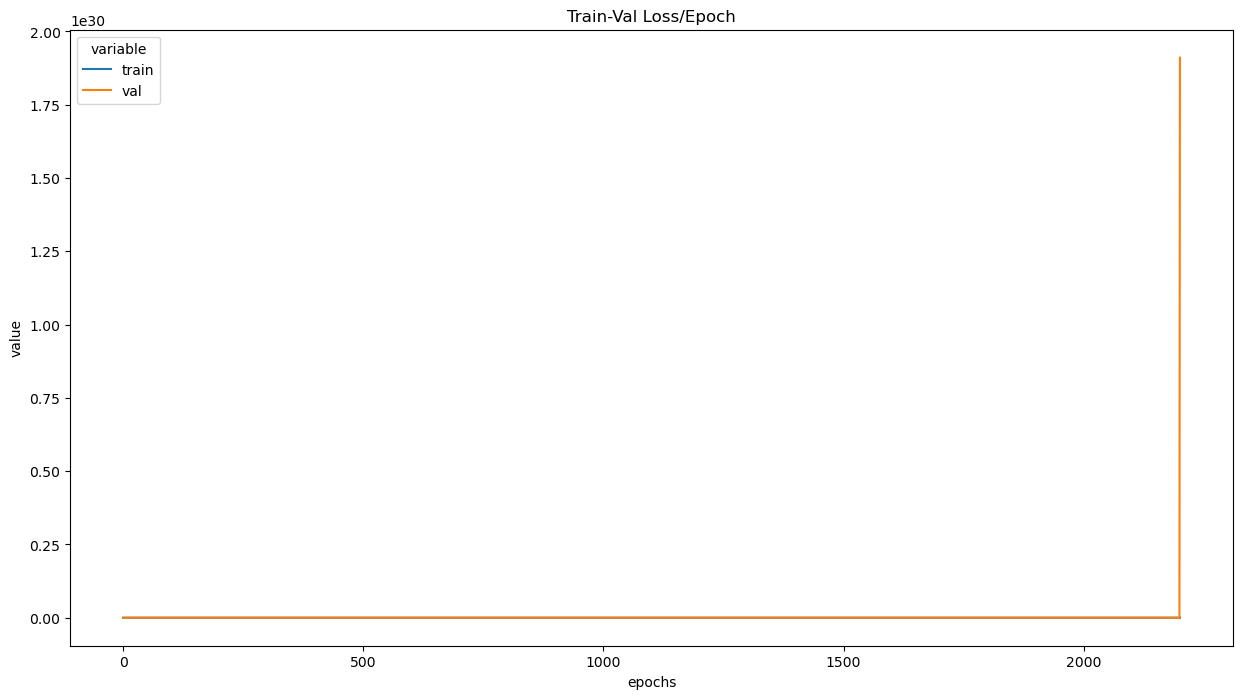

In [25]:

# read the dataset
dataset = pd.read_csv("clean_tabular_data.csv")

# For nn Regression model
target = 'Price_Night'
numeric = True

# set the supervised learning task to regression
task = 'regression'

# data preprocessing and stored in features(independent data) and label(target data)
features,label = get_processed_data(dataset, target, numeric=True)

# here split_data is a tuple where (x_train, y_train, x_val, y_val, x_test, y_test) 
# is stored by calling get_split_data()
split_data = get_split_data(features, label, task)

# here  by calling get_dataloader(), unpack the tuple split_data within function to use the split data further
train_dataloader, test_dataloader, val_dataloader = get_dataloader(split_data, task)

# get the best model, it's metrics and the best parameters
find_best_nn(train_dataloader, val_dataloader, split_data, task)
